In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from sympy import *

mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

init_printing(use_unicode=False, wrap_line=True)

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

# The Disturbing Function

We use the expansion developed in Mardling(2013), RM2013 for short. RM2013 develops two different expansions of the pertrubing part of the three body hamiltonian. The first expansion is in terms of spherical harmonics and is in principle exact in eccentricities and approximate in the ratio of semi-major axes. The second "principal" expansion is exact in the ratio of semi-major axes $\alpha=a_i/a_o$ and approximate in eccentricities, we use the first expansion here. The first expension has terms involving Hansen coefficients which are functions of the eccentricities and can in principle be calculated exactly.

The disturbing function has two parts, the secular part $\mathcal{R}_{sec}$ which doesn't depend on the fast varying longitudes and the resonant part $\mathcal{R}_{res}$. In our case, we expand the secular part up to quadropole order, in this case there exists a closed-form expression for the Hansen coefficients and the secular part is exact in the eccentricities.

For the resonant part, we use only the dominant resonant (again quadropole) term in case of the $n:1$ resonance. It is the term with $m=2$ in the RM2013 expansion. In this case however, there are no closed-form expressions for the Hansen coefficients and we can either calculate them numerically, or use a good enuogh series approximation, we opt for the latter. We can then write down the expression for the whole disturbing function.

The secular part of the distrubing function to quadropole order is

$$\mathcal{R}_{sec} = \frac{G \mu_i a_{i}^{2} m_{3} \left(\frac{3 e_{i}^{2}}{2} + 1\right)}{4 a_{o}^{3} \left(- e_{o}^{2} + 1\right)^{\frac{3}{2}}}\cos(\lambda_i - n\lambda_o+\omega_i-(2-n)\omega_o)$$

The resonant part of the disturbing function for $m=2$ and $l=2$ is given by

$$\mathcal{R}_{res} = \frac{3}{4}\frac{G\mu_im_3}{a_o}\left(\frac{a_i}{a_o}\right)^2X^{2,2}_1(e_i)\,X^{-3,2}_{n'}(e_o)$$

Where $X^{2,2}_1(e_i)$ and $X^{-3,2}_{n'}(e_o)$ are Hansen coefficients which can be calculated as a series expansion in eccentricity to arbitrary order.

## Calculation of the Hansen coefficients

This is implemented in Mathematica because for some reason it runs forever in Sympy. Unfortunately, at this point we have to specify the order of the resonance because it's not easy to calculate the Hansen coefficients for arbitrary $n$. For now, we choose $n=6$, the resulting coefficients are:

$$X^{2,2}_1(e_i) = -3e_i+\frac{13}{8}e_i^3+\frac{5}{192}e_i^5$$

$$X^{-3,2}_6(e_o)=\frac{533}{16}e_o^4-\frac{13827}{160}e_o^6+\frac{104127}{1280}e_o^8$$


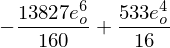

In [2]:
# Define symbols for orbital elements and constants
mu_i, mu_o, a_i, a_o, e_i, e_o, m3, n, G = \
symbols("\mu_i,\mu_o,a_i,a_o,e_i,e_o,m_3,n,G", positive=True, real=True)
R_sec, R_res, R = symbols("\mathcal{R}_{sec}, \mathcal{R}_{res}, \mathcal{R}", real=True)
lambda_i, lambda_o, w_i, w_o = symbols("\lambda_i, \lambda_o, \omega_i, \omega_o", real=True)

X_in = -3*e_i + 13*e_i**3/8
X_ou = 533*e_o**4/16 - 13827*e_o**6/160
X_ou

In [3]:
# Resonant part of the disturbing function
R_res = Rational(3,4)*G*mu_i/a_o*(a_i/a_o)**2*X_in*X_ou\
*cos(6*lambda_o - lambda_i +4*w_o + w_i)

# Secular part of the disturbing function
R_sec = G*mu_i*m3/(4*a_o)*(a_i/a_o)**2*(1 + 3*e_i**2/2)/(1 - e_o**2)**(Rational(3, 2))

The resonant part has a leading term of order $e_o^4$, for now, we only keep that term and we expand the secular part to the same order.

In [4]:
R_sec = series(R_sec, e_o, 0, 5).removeO()
R_res = series(R_res, e_o, 0, 5).removeO()

R = R_res

# Introduce Poincaré variables

Poincaré variables for the inner binary are defined as:

$$\lambda_i = \lambda_i,\quad \Lambda_i = \mu_i \sqrt{G m_{12} a_i} $$
$$\gamma_i = -\omega_i,\quad \Gamma_i = \mu_i \sqrt{G m_{12} a_i} (1-\sqrt{1-e_i^2})$$
$$z_i=0,\quad Z_i = \mu_i \sqrt{G m_{12} a_i(1-e_i^2)}$$

Similarly, for the outer binary:

$$\lambda_o = \lambda_o,\quad \Lambda_o = \mu_o \sqrt{G m_{123} a_o}$$
$$\gamma_o = -\omega_o,\quad \Gamma_o = \mu_o \sqrt{G m_{123} a_o} (1-\sqrt{1-e_o^2})$$
$$z_o=0,\quad Z_i = \mu_o \sqrt{G m_{123} a_o(1-e_o^2)}$$

We can solve the above system to obtain the expression for the orbital elements expressed in terms of Poincaré momenta. Since the new coordinates and momenta are functions of both the previous momenta and the coordinates, it is not guaranteed that the transformation is canonical, however, it is known from the literature that this transformation is canonical.

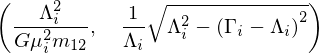

In [5]:
# Define Poincaré variables
Lambda_i, Gamma_i, Z_i, Lambda_o, Gamma_o, Z_o, m12, m123\
    = symbols("\Lambda_i, Gamma_i, Z_i, \Lambda_o, Gamma_o, Z_o, m_{12}, m_{123}",
              real=True, positive=True)  
gamma_o, gamma_i = symbols("\gamma_o, \gamma_i", real=True)
    
# Solve for orbital elements in terms of Poincaré variables
x = solve([Eq(mu_i*sqrt(G*m12*a_i) - Lambda_i),
             Eq(mu_i*sqrt(G*m12*a_i)*(1 - sqrt(1 - e_i**2)) - Gamma_i)], [a_i, e_i])

# the first sol. has neg. ecc.
x[1] 

Therefore, we, the orbital elements in terms of Poincare coordinates are given by:

$$a_i = \frac{\Lambda_i^{2}}{G \mu_i^{2} m_{12}}$$

$$e_i = \frac{1}{\Lambda_i} \sqrt{\Lambda_i^{2} - \left(\Gamma_{i} - \Lambda_i\right)^{2}}$$

and for the outer part:

$$a_o = \frac{\Lambda_o^{2}}{G \mu_o^{2} m_{123}}$$

$$e_o = \frac{1}{\Lambda_o} \sqrt{\Lambda_o^{2} - \left(\Gamma_{o} - \Lambda_o\right)^{2}}$$

we can now write the Disturbing function in Poincaré variables:

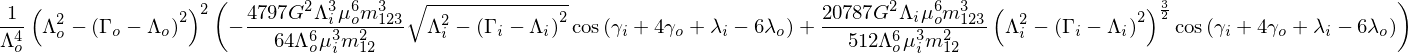

In [6]:
# Disturbing function in Poincaré coordinates
R = R.subs({a_i: Lambda_i**2/(G*mu_i**2*m12),
            e_i: sqrt(Lambda_i**2 - (Gamma_i - Lambda_i)**2)/Lambda_i,
            a_o: Lambda_o**2/(G*mu_o**2*m123),
            e_o: sqrt(Lambda_o**2 - (Gamma_o - Lambda_o)**2)/Lambda_o,
            w_i: -gamma_i,
            w_o: -gamma_o})
R

# The complete Hamiltonian in Poincaré coordinates

### The Keplerian part

The complete Hamiltonian of the three body system is given by 

$$\mathcal{H}=\mathcal{H}_{kepler}-\mathcal{R}$$

where $\mathcal{H}_{kepler}$ is the Keplerian part.

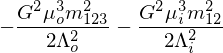

In [7]:
H = Symbol('\mathcal{H}', real=True)
H_k = Symbol('mathcal{H}_{Kepler}', real=True)
H_k = - G**2*m12**2*mu_i**3/(2*Lambda_i**2) - G**2*m123**2*mu_o**3/(2*Lambda_o**2)
H_k

$$\mathcal{H}_{Kepler}=- \frac{G^{2} \mu_o^{3} m_{123}^{2}}{2 \Lambda_o^{2}} - \frac{G^{2} \mu_i^{3} m_{12}^{2}}{2 \Lambda_i^{2}}$$

Since we're interested in behaviour close to resonance, we can expanded the Keplerian Hamiltonain in a series around a $\Lambda$ wchich corresponds to exact resonance, we denote this value of $\Lambda$ as $[\Lambda]$.

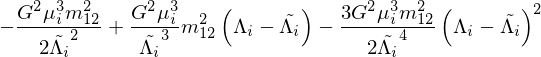

In [10]:
LLambda_o, LLambda_i  = symbols(r"\tilde{\Lambda_o}, \tilde{\Lambda_i}", real=True, positive=True)
tmp1 = series(H_k.args[0], Lambda_i, LLambda_i, 3).removeO()
tmp1
tmp2 = series(H_k.args[1], Lambda_o, LLambda_o, 3).removeO()
H_k = expand(tmp1 + tmp2)
H_k.args

In [9]:
H_k_exp = H_k.args[2] + H_k.args[3] + H_k.args[4] + H_k.args[5]
n_i, n_o, h_i, h_o = symbols(r"\tilde{n_i} \tilde{n_o} \tilde{h_i} \tilde{h_o}",
                             real=True, positive=True)

IndexError: tuple index out of range

This can be written as

$$\mathcal{H}_{Kepler}=4([n_i]\Lambda_i + [n_o]\Lambda_o) - \frac{3}{2}([h_i]\Lambda_i^2 + [h_o]\Lambda_o^2)$$

where

$$[n_i]=\sqrt{\frac{Gm_{12}}{[a_i]^3}}\quad[n_o]=\sqrt{\frac{Gm_{123}}{[a_o]^3}}$$

and

$$[h_i]=\frac{1}{\mu_i[a_i]^2}\quad[h_o]=\frac{1}{\mu_o[a_o]^2}$$

In [ ]:
sol = solve([
    Eq(n_i - sqrt(G*m12/a_i**3)),
    Eq(Lambda_i - mu_i*sqrt(G*m12*a_i))], [a_i, Lambda_i])

sol[0]

In [ ]:
H_k_exp = H_k_exp.subs({
    LLambda_i: n_i/h_i,
    LLambda_o: n_o/h_o,
    m12: n_i**2*(mu_i*h_i)**(-Rational(3,2))/G,
    m123: n_o**2*(mu_o*h_o)**(-Rational(3,2))/G
})
H_k_exp

### The disturbing function part

We expand the disturbing function part of the hamiltonian to lowest order in $\Gamma_i$ and 
$\Gamma_o$. The resulting function is proportional to

$$\mathcal{R}\propto \sqrt{\Gamma_i}{\Gamma_o^2} + \mathcal{O}(\Gamma_i, \Gamma_o^3)$$

In [ ]:
H_dist = -R

H_dist = H_dist.subs({
    Lambda_i: LLambda_i,
    Lambda_o: LLambda_o,
    m12: n_i**2*(mu_i*h_i)**(-Rational(3,2))/G,
    m123: n_o**2*(mu_o*h_o)**(-Rational(3,2))/G
})

H_dist
series(series(H_dist, Gamma_i, 0, 1).removeO(), Gamma_o, 0, 3)

In [ ]:
H_dist = series(series(H_dist, Gamma_i, 0, 1).removeO(), Gamma_o, 0, 3).removeO()

### Complete Hamiltonian

We will also use the resonant relationship

$$n_i^*=6n_o^*$$

and eliminate $\Lambda_i^*$ and $\Lambda_o^*$ via

$$n_i^*=h_i^*\Lambda_i^*$$

In [ ]:
H_dist = H_dist.subs({
    n_o: n_i/6,
    LLambda_i: n_i/h_i,
    LLambda_o: (n_i/6)/h_o
})
H_dist

In [ ]:
H_k_exp = H_k_exp.subs({
    n_o: n_i/6,
    LLambda_i: n_i/h_i,
    LLambda_o: (n_i/6)/h_o
})
H_k_exp

In [ ]:
# Redefine constant in front of the cosine term
f_1 = symbols(r"f_1", real=True, positive=True)
H_dist = f_1*sqrt(Gamma_i)*Gamma_o**2*cos(gamma_i +4*gamma_o +lambda_i - 6*lambda_o)
H_dist

In [ ]:
H = H_k_exp + H_dist
H

# Reduction to one degree of freedom

In order to reduce the above Hamiltonian to a single degree of freedom, we make use of a canonical transformation which uses the harmonic angle as one of the new conjugate positions. The transformation is of the form:

$$(\lambda_i, \lambda_o,\gamma_i, \gamma_o, \Lambda_i, \Lambda_o, \Gamma_i, \Gamma_o)
\rightarrow(\theta_1, \theta_2, \theta_3, \theta_4, \Theta_1, \Theta_2, \Theta_3, \Theta_4)$$

it is generated by the generating function of the 2nd type defined below.

In [ ]:
t1, t2, t3, t4, T1, T2, T3, T4 =\
symbols(r"\theta_1, \theta_2, \theta_3, \theta_4, \Theta_1, \Theta_2, \Theta_3, \Theta_4",
        real=True)

# Specify F2
n = 6
F2 = ((-n*lambda_o + lambda_i + gamma_i)/(n - 2) + gamma_o)*T1\
    +(n*lambda_o - lambda_i + gamma_i)*T2 + lambda_i*T3 + lambda_o*T4

H = H.subs({
    Lambda_i: diff(F2, lambda_i),
    Lambda_o: diff(F2, lambda_o),
    Gamma_i: diff(F2, gamma_i),
    Gamma_o: diff(F2, gamma_o),
    gamma_o: t1 -(n*lambda_o - lambda_i - gamma_i)/(2 - n)
})

sol = solve([
    Eq(diff(F2, lambda_i) - Lambda_i),
    Eq(diff(F2, lambda_o) - Lambda_o),
    Eq(diff(F2, gamma_i) - Gamma_i),
    Eq(diff(F2, gamma_o) - Gamma_o)], [T1, T2, T3 ,T4])
sol

In [ ]:
H

The square root next to the cosine term is problematic, we thus use the approximation $\Theta_1\ll\Theta_2$. This approximation relies on the fact that $\frac{\Gamma_o}{\Gamma_i}$ is small which is true only if $m_3$ is small compared to $m_1$ and $m_2$ and if $e_o<e_i$. The approximation breaks down when the outer eccentricty surpasses the inner.

Finally, after expanding everything and neglecting the constant terms, we obtain:

In [ ]:
T, t = symbols(r"\Theta \theta", real=True)
H = H.subs({
    f_1: f_1*(1/sqrt(T1/4 + T2))*sqrt(T2),
})
H

In [ ]:
H = H.subs({
    T1: T,
    t1: t,
    T2: Gamma_i - Gamma_o/4,
    T3: Gamma_i - Gamma_o/2 + Lambda_i,
    T4: -6*Gamma_i + 3*Gamma_o + Lambda_o
})
simplify(H)

In [ ]:
H = collect(expand(H), T).args[0] + collect(expand(H), T).args[1]
H

In [ ]:
H = collect(expand(H/(h_o*Lambda_o)), T)
H

# Analysis of bifurcation points

In [ ]:
tdot = simplify(diff(H, T))
simplify(solve(Eq(tdot), T))

In [ ]:
Tdot = -simplify(diff(H, t))
Tdot

In [ ]:
sol2 = solve([
    Eq(tdot),
    Eq(Tdot)], [T, t])

sol2

Finally, we define the following mixed canonical transformation:



In [ ]:
# x, y = symbols("x, y", real=True)
# H = H.subs({
#     Theta: (x**2 + y**2)/2,
#     theta: acos(x/sqrt(x**2 + y**2))
# })
# H 